In [1]:
import pandas, geopandas,shapely, contextily

vetted_allisions_w_coords = pandas.read_csv('data/processed/etl_6_allisions_w_coords.csv',index_col=0)

> USING RECORDS FROM THE U-S COAST GUARD, OUR INVESTIGATION FOUND A VESSEL HAS DRIFTED INTO PART OF A BRIDGE SOMEWHERE IN THE U-S AT LEAST 650 TIMES SINCE 20-19.

In [2]:
vetted_allisions_w_coords["activity_id"].nunique()

650

In [3]:
vetted_allisions_w_coords.columns

Index(['index', 'activity_id', 'title', 'start_dt', 'end_dt', 'page',
       'Not at Risk', 'At Risk, Not Injured', 'Dead', 'Injured', 'Unnamed: 9',
       'Missing', 'cargo_damage', 'facility_damage', 'vessel_damage',
       'other_damage', 'serious_marine_incident', 'marine_board_convened',
       'invest_level', 'casualty_classification', 'incident_involvement',
       'invest_type', 'brief', 'facility_name', 'vessel_name',
       'primary_vessel_id', 'year', 'facility_damage_review',
       'ambiguous_facility_cost', 'geometry', 'description', 'waterway_name',
       'summary_point', 'lat', 'long', 'STUSPS', 'GEOID', 'NAMELSAD',
       'county_state'],
      dtype='object')

> OUR ANALYSIS DISCOVERED THAT IN OVER A HUNDRED OF THESE CASES, THE IMPACT WAS HARD ENOUGH TO REQUIRE REPAIRS TO THE STRUCTURE. 

In [10]:
vetted_allisions_w_coords.groupby(vetted_allisions_w_coords["facility_damage"]>0)["activity_id"].nunique()

vetted_allisions_w_coords.pivot_table(index=vetted_allisions_w_coords["facility_damage"]>0,columns=vetted_allisions_w_coords["ambiguous_facility_cost"]!=True,values="activity_id",aggfunc="nunique")

ambiguous_facility_cost,False,True
facility_damage,,
False,NaN,541.0
True,1.0,108.0


> WE FOUND A LOT OF THE BRIDGES GETTING STRUCK AGAIN AND AGAIN ARE OVER THE SAME BODY OF WATER: THE MISSISSIPPI RIVER. 

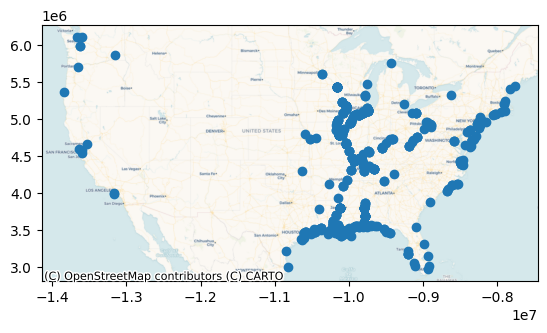

In [5]:
allisions_w_coords_geo = geopandas.GeoDataFrame(vetted_allisions_w_coords, geometry=vetted_allisions_w_coords["summary_point"].apply(shapely.wkt.loads), crs="EPSG:4326")
allisions_w_coords_geo = allisions_w_coords_geo.to_crs(epsg=3857)
ax = allisions_w_coords_geo.plot()
contextily.add_basemap(ax,source=contextily.providers.CartoDB.Voyager)

In [6]:
def str_to_ls(s):
    if s == "[]":
        return([])
    ls = str(s.strip())[1:-1].split(",")
    for i in range(len(ls)):
        ls[i] = str(ls[i].replace("'","")).strip()
    return ls

vetted_allisions_w_coords["waterway_name_ls"] = vetted_allisions_w_coords["waterway_name"].apply(str_to_ls)

value_counts_by_waterway_name = vetted_allisions_w_coords["waterway_name_ls"].explode().str.upper().value_counts()

value_counts_by_waterway_name[value_counts_by_waterway_name.index.str.contains("MISSISSIPPI")]

waterway_name_ls
MISSISSIPPI-UP    114
MISSISSIPPI-LO     56
Name: count, dtype: int64

> WE'VE LEARNED HUNDREDS OF SHIPS HAVE CRASHED INTO BRIDGES ALL OVER THE COUNTRY.

In [7]:

vetted_allisions_w_coords["primary_vessel_id_ls"] = vetted_allisions_w_coords["primary_vessel_id"].apply(str_to_ls)

count_unique_single_vessel_incident_vessels = vetted_allisions_w_coords[vetted_allisions_w_coords["primary_vessel_id_ls"].apply(len)==1]["primary_vessel_id_ls"].explode().nunique()
count_unique_single_vessel_incident_vessels

189

In [8]:
# How many cases are there where _ALL_ vessels involved are not involved in other cases (i.e. they only appear in the data once)

vessel_level = vetted_allisions_w_coords.explode("primary_vessel_id_ls").reset_index()
vessel_counts = vessel_level["primary_vessel_id_ls"].value_counts()
repeat_vessels = vessel_counts[vessel_counts>1]
repeat_vessel_incidents = vessel_level[vessel_level["primary_vessel_id_ls"].isin(repeat_vessels.index)]["activity_id"].unique()
count_multivessel_incidents_only_involving_onetime_vessels =  vetted_allisions_w_coords[(vetted_allisions_w_coords["primary_vessel_id_ls"].apply(len)!=1) & ~(vetted_allisions_w_coords["activity_id"].isin(repeat_vessel_incidents))]["activity_id"].nunique()
count_multivessel_incidents_only_involving_onetime_vessels

262

In [9]:
count_multivessel_incidents_only_involving_onetime_vessels + count_unique_single_vessel_incident_vessels

451